In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.random import seed
from scipy.stats import ttest_ind
from scipy.stats import t

In [47]:
#reading in users csv file - parsing dates to ensure they have a datetime format
users = pd.read_csv('/home/amybirdee/hobby_projects/click_d/users.csv', delimiter = ',', parse_dates = ['PROFILE_REGISTERED']) 

In [48]:
users.head()

,UID,PROFILE_GENDER,PROFILE_REGISTERED,AGE
0,7904,M,2018-11-11 14:51:45,27
1,4456,M,2018-11-10 20:32:04,28
2,5801,M,2018-11-10 23:56:36,34
3,2724,M,2018-11-11 12:08:59,23
4,6532,M,2018-11-11 02:35:24,24


In [49]:
#reading in events data - parsing dates to ensure they have a datetime format
events = pd.read_csv('/home/amybirdee/hobby_projects/click_d/events.csv', delimiter = ',', parse_dates = ['ACTION_TS'])

In [50]:
events.head()

,ACTIVE_UID,ACTION_TS,DEV_NAME,EVENT
0,138,2018-11-11 17:56:27,device_type_1,action_2
1,138,2018-11-11 17:56:28,device_type_1,action_1
2,138,2018-11-11 18:13:03,device_type_1,action_1
3,138,2018-11-11 18:18:36,device_type_1,action_2
4,138,2018-11-11 18:19:39,device_type_1,action_2


## Cohort analysis

In [51]:
#dropping gender, age and ab_group columns as not needed in analysis
users_cohort = users.drop(['PROFILE_GENDER', 'AGE'], axis = 1)

In [52]:
#changing column names in users table
users_cohort = users_cohort.rename(columns = {'UID': 'user_id', 'PROFILE_REGISTERED': 'registration_date'})
users_cohort.head()

,user_id,registration_date
0,7904,2018-11-11 14:51:45
1,4456,2018-11-10 20:32:04
2,5801,2018-11-10 23:56:36
3,2724,2018-11-11 12:08:59
4,6532,2018-11-11 02:35:24


In [53]:
#dropping device column as not needed in analysis
events_cohort = events.drop('DEV_NAME', axis = 1)

In [54]:
#changing column names in events table
events_cohort = events_cohort.rename(columns = {'ACTIVE_UID': 'user_id', 'ACTION_TS': 'active_date', 'EVENT': 'event'})
events_cohort.head()

,user_id,active_date,event
0,138,2018-11-11 17:56:27,action_2
1,138,2018-11-11 17:56:28,action_1
2,138,2018-11-11 18:13:03,action_1
3,138,2018-11-11 18:18:36,action_2
4,138,2018-11-11 18:19:39,action_2


In [55]:
#removing rows with app start as the event as only want to include an actual event (left or right swipe) in the analysis
events_cohort = events_cohort.drop(events_cohort[events_cohort['event'] == 'app_start'].index)

In [56]:
#renaming the remaining events to left or right swipe
events_cohort['event'] = events_cohort['event'].map({'action_1': 'left or right swipe', 'action_2':'left or right swipe'})
events_cohort.head()

,user_id,active_date,event
0,138,2018-11-11 17:56:27,left or right swipe
1,138,2018-11-11 17:56:28,left or right swipe
2,138,2018-11-11 18:13:03,left or right swipe
3,138,2018-11-11 18:18:36,left or right swipe
4,138,2018-11-11 18:19:39,left or right swipe


In [57]:
#merging two tables
merged_cohort = users_cohort.merge(events_cohort, left_on = 'user_id', right_on = 'user_id')
merged_cohort.head()

,user_id,registration_date,active_date,event
0,7904,2018-11-11 14:51:45,2018-11-14 20:18:54,left or right swipe
1,7904,2018-11-11 14:51:45,2018-11-11 15:05:40,left or right swipe
2,7904,2018-11-11 14:51:45,2018-11-11 15:05:35,left or right swipe
3,7904,2018-11-11 14:51:45,2018-11-11 15:21:47,left or right swipe
4,7904,2018-11-11 14:51:45,2018-11-11 15:21:48,left or right swipe


In [58]:
merged_cohort = merged_cohort.sort_values(by = ['user_id', 'registration_date', 'active_date']).reset_index(drop = True)

In [59]:
#checking datatypes - need to change dates from object to date
merged_cohort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129984 entries, 0 to 129983
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            129984 non-null  int64         
 1   registration_date  129984 non-null  datetime64[ns]
 2   active_date        129984 non-null  datetime64[ns]
 3   event              129984 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 4.0+ MB


In [60]:
#splitting date from datetime
merged_cohort['registration_date'] = merged_cohort['registration_date'].dt.date
merged_cohort['active_date'] = merged_cohort['active_date'].dt.date
merged_cohort.head()

,user_id,registration_date,active_date,event
0,46,2018-11-10,2018-11-10,left or right swipe
1,46,2018-11-10,2018-11-10,left or right swipe
2,46,2018-11-10,2018-11-10,left or right swipe
3,46,2018-11-10,2018-11-10,left or right swipe
4,46,2018-11-10,2018-11-10,left or right swipe


In [61]:
#adding column to show number of days passed between registration date and active date
merged_cohort['days_passed_since_registration'] = merged_cohort['active_date'] - merged_cohort['registration_date']
merged_cohort.head()

,user_id,registration_date,active_date,event,days_passed_since_registration
0,46,2018-11-10,2018-11-10,left or right swipe,0 days
1,46,2018-11-10,2018-11-10,left or right swipe,0 days
2,46,2018-11-10,2018-11-10,left or right swipe,0 days
3,46,2018-11-10,2018-11-10,left or right swipe,0 days
4,46,2018-11-10,2018-11-10,left or right swipe,0 days


In [62]:
#grouping the data by active date and days passed and unique user ids - nunique counts number of unique values
cohort = merged_cohort.groupby(['registration_date', 'days_passed_since_registration']).user_id.nunique().reset_index()
cohort

,registration_date,days_passed_since_registration,user_id
0,2018-11-10,0 days,39
1,2018-11-10,1 days,34
2,2018-11-10,2 days,26
3,2018-11-10,3 days,26
4,2018-11-10,4 days,16
5,2018-11-11,0 days,50
6,2018-11-11,1 days,43
7,2018-11-11,2 days,38
8,2018-11-11,3 days,37
9,2018-11-11,4 days,22


In [63]:
#pivoting the date to group by active date and days passed
cohort_pivot = cohort.pivot_table(columns = 'days_passed_since_registration',
                                 index = 'registration_date',
                                 values = 'user_id')
cohort_pivot

days_passed_since_registration,0 days,1 days,2 days,3 days,4 days
registration_date,,,,,
2018-11-10,39,34,26,26,16
2018-11-11,50,43,38,37,22


In [64]:
#converting to dataframe
cohort_pivot_df = cohort_pivot.reset_index()
cohort_pivot_df

days_passed_since_registration,registration_date,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00
0,2018-11-10,39,34,26,26,16
1,2018-11-11,50,43,38,37,22


In [65]:
#converting all columns to string as chart isn't accepting the non-string columns
cohort_pivot_df.columns = cohort_pivot_df.columns.astype(str)

In [66]:
#renaming the columns
cohort_pivot_df = cohort_pivot_df.rename(columns = {'0 days 00:00:00': '0 days', '1 days 00:00:00': '1 day', '2 days 00:00:00': \
                                              '2 days', '3 days 00:00:00': '3 days', '4 days 00:00:00': '4 days'})
cohort_pivot_df

days_passed_since_registration,registration_date,0 days,1 day,2 days,3 days,4 days
0,2018-11-10,39,34,26,26,16
1,2018-11-11,50,43,38,37,22


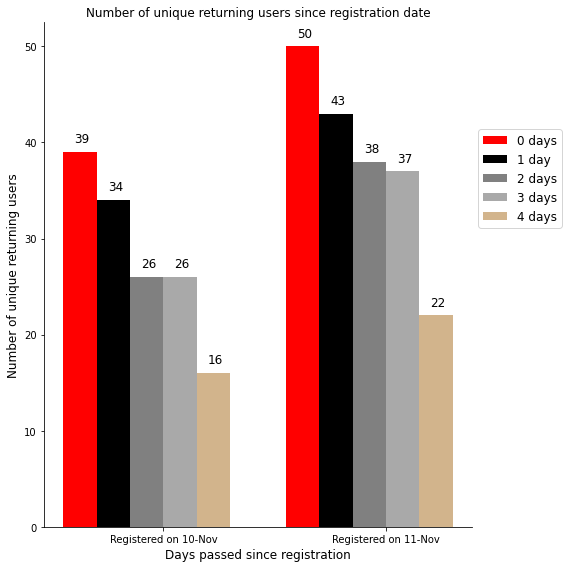

In [67]:
num_bars = 2
width = 0.15

cohort_bars = np.arange(num_bars)
labels = ['Registered on 10-Nov', 'Registered on 11-Nov']

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

bar_1 = ax.bar(cohort_bars, cohort_pivot_df['0 days'], width, color = 'red', label = '0')
bar_2 = ax.bar(cohort_bars + 0.15, cohort_pivot_df['1 day'], width, color = 'black', label = '1')
bar_3 = ax.bar(cohort_bars + 0.3, cohort_pivot_df['2 days'], width, color = 'grey', label = '2')
bar_4 = ax.bar(cohort_bars + 0.45, cohort_pivot_df['3 days'], width, color = 'darkgrey', label = '3')
bar_5 = ax.bar(cohort_bars + 0.6, cohort_pivot_df['4 days'], width, color = 'tan', label = '4')

#removing chart borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#adding data labels
for bar in bar_1:
    yval = bar.get_height()
    ax.text(bar.get_x() + 0.05, yval + 1, yval, fontsize = 12)
    
for bar in bar_2:
    yval = bar.get_height()
    ax.text(bar.get_x() + 0.05, yval + 1, yval, fontsize = 12)
    
for bar in bar_3:
    yval = bar.get_height()
    ax.text(bar.get_x() + 0.05, yval + 1, yval, fontsize = 12)

for bar in bar_4:
    yval = bar.get_height()
    ax.text(bar.get_x() + 0.05, yval + 1, yval, fontsize = 12)
    
for bar in bar_5:
    yval = bar.get_height()
    ax.text(bar.get_x() + 0.05, yval + 1, yval, fontsize = 12)


ax.set_ylabel('Number of unique returning users', fontsize = 12)
ax.set_xlabel('Days passed since registration', fontsize = 12)
ax.set_xticks(cohort_bars + (width * 5) / 2)
ax.set_xticklabels(labels)
ax.legend((bar_1, bar_2, bar_3, bar_4, bar_5), ('0 days', '1 day', '2 days', '3 days', '4 days'), bbox_to_anchor = \
          (1.0, 0.8), fontsize = 12)
ax.set_title('Number of unique returning users since registration date', fontsize = 12)
plt.tight_layout()
plt.savefig('cohort')

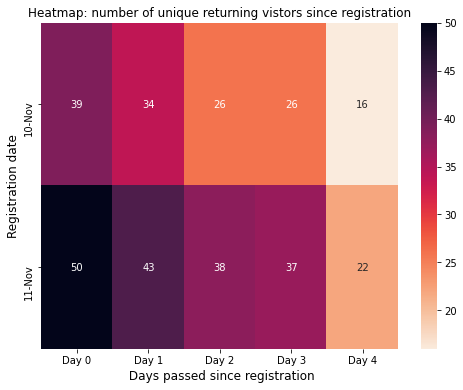

In [68]:
#creating heatmap. The default color scheme is sns.cm.rocket - the code cmap = sns.cm.rocket_r reverses this so 
#higher numbers are darker and lower numbers are ligher
xticks = ['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4']
yticks = ['10-Nov', '11-Nov']
cmap = sns.cm.rocket_r

plt.figure(figsize = (8, 6))
sns.heatmap(cohort_pivot, xticklabels = xticks, yticklabels = yticks, annot = True, cmap = cmap)
plt.title('Heatmap: number of unique returning vistors since registration', fontsize = 12)
plt.xlabel(' Days passed since registration', fontsize = 12)
plt.ylabel('Registration date', fontsize = 12)
plt.savefig('heatmap')

## Assigning random A/B test groups

In [69]:
#setting the seed in order to replicate results
seed(26)

In [70]:
#adding a random number to each user to assign them into A and B test groups
users['random_number'] = np.random.randint(1, 3, users.shape[0])
users.head()

,UID,PROFILE_GENDER,PROFILE_REGISTERED,AGE,random_number
0,7904,M,2018-11-11 14:51:45,27,2
1,4456,M,2018-11-10 20:32:04,28,1
2,5801,M,2018-11-10 23:56:36,34,1
3,2724,M,2018-11-11 12:08:59,23,1
4,6532,M,2018-11-11 02:35:24,24,2


In [71]:
#assiging A and B groups
users['group'] = users['random_number'].apply(lambda row: 'A' if row == 1 else 'B')
users.head()

,UID,PROFILE_GENDER,PROFILE_REGISTERED,AGE,random_number,group
0,7904,M,2018-11-11 14:51:45,27,2,B
1,4456,M,2018-11-10 20:32:04,28,1,A
2,5801,M,2018-11-10 23:56:36,34,1,A
3,2724,M,2018-11-11 12:08:59,23,1,A
4,6532,M,2018-11-11 02:35:24,24,2,B


In [72]:
#dropping the random number and profile registered columns as no longer needed
users_ab = users.drop(['random_number', 'PROFILE_REGISTERED'], axis = 1).reset_index(drop = True)
users_ab.head()

,UID,PROFILE_GENDER,AGE,group
0,7904,M,27,B
1,4456,M,28,A
2,5801,M,34,A
3,2724,M,23,A
4,6532,M,24,B


In [73]:
#renaming columns
users_ab = users_ab.rename(columns = {'UID': 'user_id', 'PROFILE_GENDER': 'gender', 'AGE': 'age'})
users_ab.head()

,user_id,gender,age,group
0,7904,M,27,B
1,4456,M,28,A
2,5801,M,34,A
3,2724,M,23,A
4,6532,M,24,B


In [74]:
#dropping date and device name columns as not needed in analysis
events_ab = events.drop(['ACTION_TS', 'DEV_NAME'], axis = 1).reset_index(drop = True)
events_ab.head()

,ACTIVE_UID,EVENT
0,138,action_2
1,138,action_1
2,138,action_1
3,138,action_2
4,138,action_2


In [75]:
#renaming columns
events_ab = events_ab.rename(columns = {'ACTIVE_UID': 'user_id', 'EVENT': 'event'})
events_ab.head()

,user_id,event
0,138,action_2
1,138,action_1
2,138,action_1
3,138,action_2
4,138,action_2


In [76]:
#merging tables
merged_ab = users_ab.merge(events_ab, left_on = 'user_id', right_on = 'user_id')
merged_ab.head()

,user_id,gender,age,group,event
0,7904,M,27,B,action_1
1,7904,M,27,B,action_2
2,7904,M,27,B,action_1
3,7904,M,27,B,action_1
4,7904,M,27,B,action_1


In [77]:
#removing rows with app start as the event as only want to include an actual event in the analysis
merged_ab = merged_ab.drop(merged_ab[merged_ab['event'] == 'app_start'].index)

In [78]:
#assigning events for A/B test groups - group A: left swipe = no, right swipe = yes. Group B: down swipe = no,
#up swipe = yes 

def swipe(row):
    if row['group'] == 'A' and row['event'] == 'action_1':
        value = 'right swipe'
    elif row['group'] == 'A' and row['event'] == 'action_2':
        value = 'left swipe'
    elif row['group'] == 'B' and row['event'] == 'action_1':
        value = 'up swipe'
    else:
        value = 'down swipe'
    return value

In [79]:
#applying the function to the merged dataframe and viewing a sample of the results. The frac = 0.0001 tells Python what
#fraction of the data you want to see
merged_ab['swipe_direction'] = merged_ab.apply(swipe, axis = 1) 
merged_ab.sample(frac = 0.0001)

,user_id,gender,age,group,event,swipe_direction
22631,9163,M,29,B,action_2,down swipe
32833,12331,F,41,B,action_2,down swipe
41778,12331,F,41,B,action_2,down swipe
55846,12121,M,32,A,action_2,left swipe
118790,12182,M,32,B,action_1,up swipe
68992,4685,M,31,B,action_1,up swipe
79017,2360,M,32,B,action_2,down swipe
55012,5795,F,35,B,action_2,down swipe
135198,5454,M,36,B,action_1,up swipe
30821,4307,F,29,A,action_2,left swipe


## Analysing A/B test results with a t-test

In [80]:
ab_group_data = merged_ab.groupby(['user_id', 'group']).size().to_frame().sort_values('user_id').\
reset_index().rename(columns = {0: 'swipe_count'})
ab_group_data.head()

,user_id,group,swipe_count
0,46,B,1524
1,84,B,358
2,138,B,886
3,353,A,77
4,500,B,2217


In [81]:
#counting users in A and B test groups
count_users = ab_group_data.groupby('group').count()
count_users

,user_id,swipe_count
group,,
A,49,49
B,43,43


In [82]:
#testing for 95% convidence level
#null hypothesis: the average number of swipes is no different between left/right swipe and up/down swipe
#alternative hypothesis: the average number of swipes is higher for up/down swipes than left/right swipes

In [83]:
#calculating average number of swipes for each group - average is higher for Group B (up/down swipe)
average_swipes = ab_group_data.groupby('group').swipe_count.mean()
average_swipes

group
A    1072.714286
B    1800.488372
Name: swipe_count, dtype: float64

In [84]:
#creating pivot for t-test to see if results are statistically significant
ab_pivot = ab_group_data.pivot_table(columns = 'group',
                                    index = 'user_id',
                                    values = 'swipe_count')
ab_pivot

group,A,B
user_id,,
46,NaN,1524.0
84,NaN,358.0
138,NaN,886.0
353,77.0,NaN
500,NaN,2217.0
...,...,...
12339,NaN,4357.0
12632,NaN,26.0
12847,NaN,176.0


In [85]:
#creating dataframe from pivot to feed into t-test
ab_ttest = ab_pivot.reset_index()
ab_ttest.head()

group,user_id,A,B
0,46,NaN,1524.0
1,84,NaN,358.0
2,138,NaN,886.0
3,353,77.0,NaN
4,500,NaN,2217.0


In [86]:
#performing t-test and getting the t statistic and p value. The nan_policy code tells Python to omit nans
#this p-value is for a two-tailed test. To get the p-value for a one-tailed test, we divide the p-value by 2
t_stat, p = ttest_ind(ab_ttest['A'], ab_ttest['B'], nan_policy = 'omit')
print(f't stat = {t_stat}, p value = {p}')

t stat = -1.5443911282502167, p value = 0.12600272040577903


In [87]:
#calculating p-value for one-tailed test. P-value is greater than 0.05 and therefore the results are not significant and 
#likely happened by change. We therefore cannot reject the null hypothesis and would not implement version B in this case
p_value_one_tailed = 0.12600272040577903 / 2
p_value_one_tailed

0.06300136020288952